## Visión por Computadora 1 - Cohorte 17
## Trabajo Práctico 3
## Paola Cartala - Florentino Arias

## Parte 1: Detección del logo en cada imagen sin falsos positivos.
Vamos a utilizar matchTemplate() de OpenCV para implementar el método de template matching.

Para solucionar el problema de las escalas del template al comparar, implementamos una función que devuelve una lista de imágenes que van escalando a menor progresivamente de acuerdo a un paso de escalas. Vamos comparando usando el template en sus distintas escalas y nos quedamos con el que arroje la mejor métrica en el matching.

Tamaño del template original: (175, 400)
La similitud máxima fue de 0.30
El mejor tamaño del template fue de (52, 120)
El mejor tamaño de la imagen fue de (756, 756)


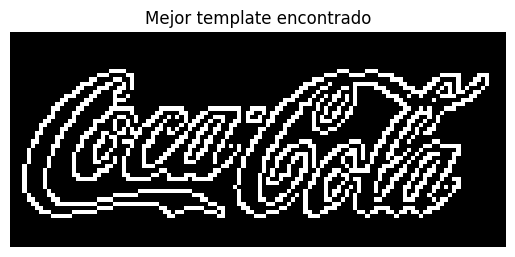

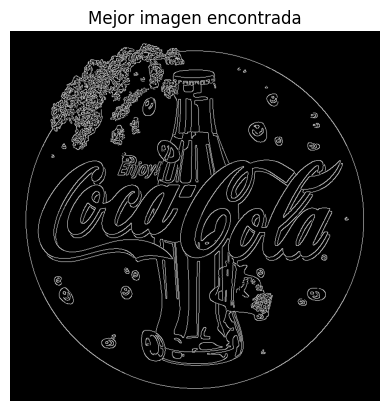

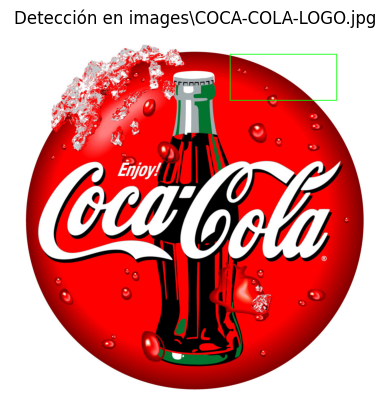

La similitud máxima fue de 0.41
El mejor tamaño del template fue de (95, 218)
El mejor tamaño de la imagen fue de (639, 264)


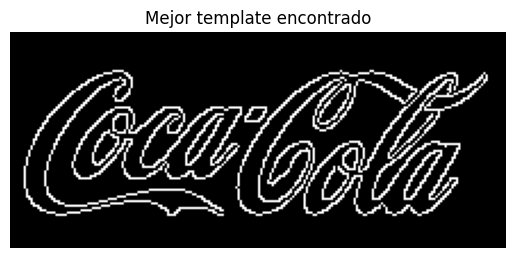

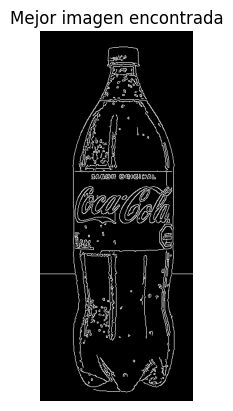

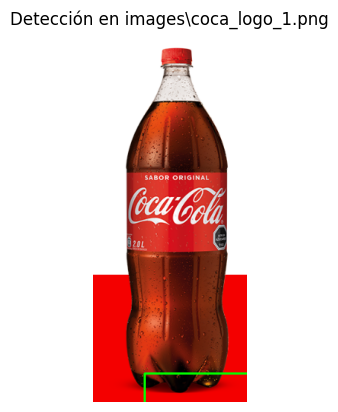

La similitud máxima fue de 0.30
El mejor tamaño del template fue de (52, 120)
El mejor tamaño de la imagen fue de (198, 127)


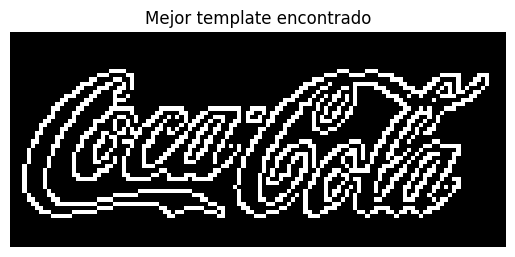

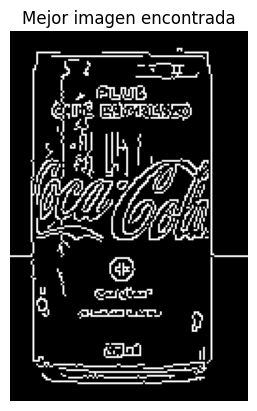

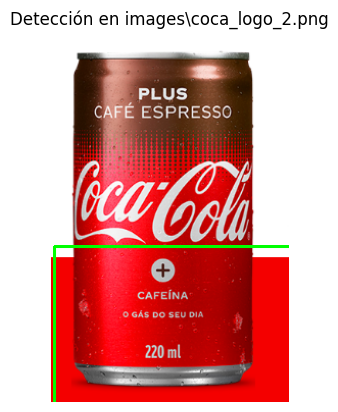

La similitud máxima fue de 0.40
El mejor tamaño del template fue de (52, 120)
El mejor tamaño de la imagen fue de (764, 1021)


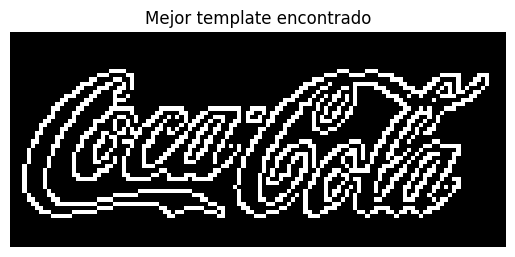

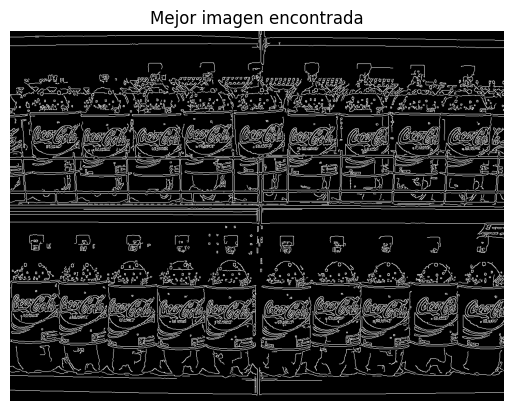

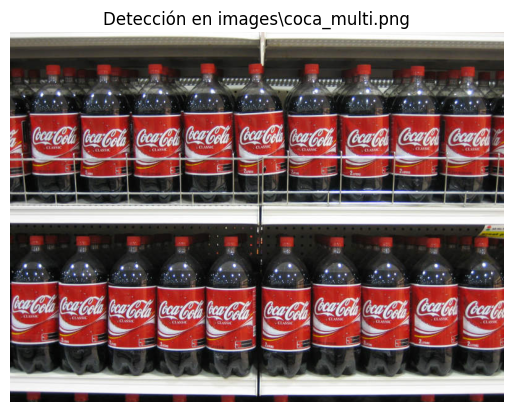

La similitud máxima fue de 0.31
El mejor tamaño del template fue de (52, 120)
El mejor tamaño de la imagen fue de (148, 214)


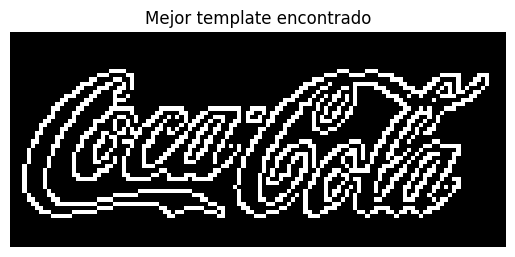

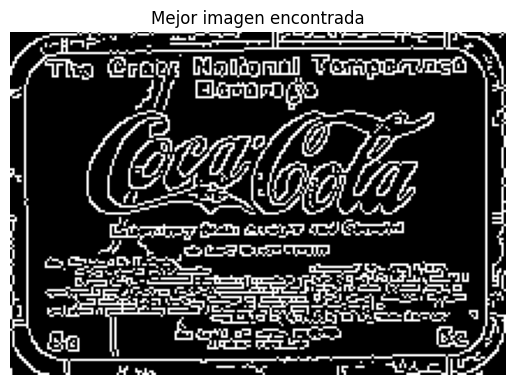

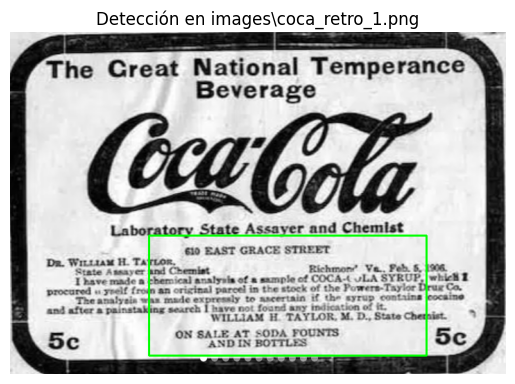

La similitud máxima fue de 0.45
El mejor tamaño del template fue de (52, 120)
El mejor tamaño de la imagen fue de (338, 564)


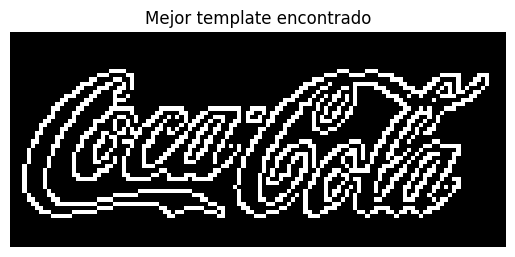

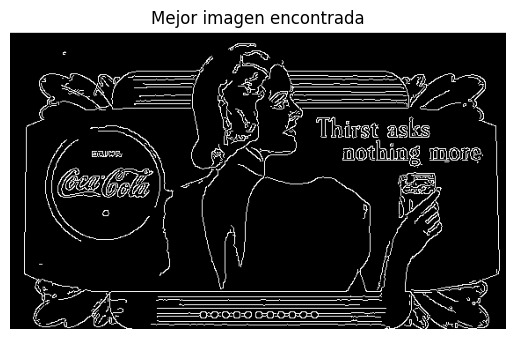

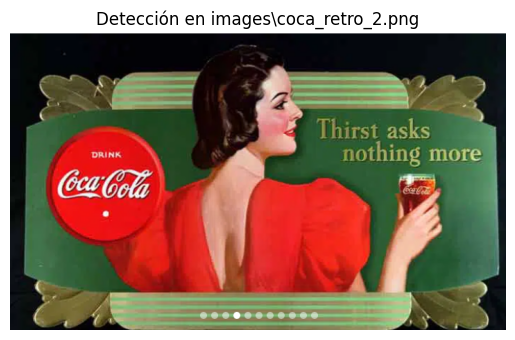

La similitud máxima fue de 0.29
El mejor tamaño del template fue de (52, 120)
El mejor tamaño de la imagen fue de (245, 374)


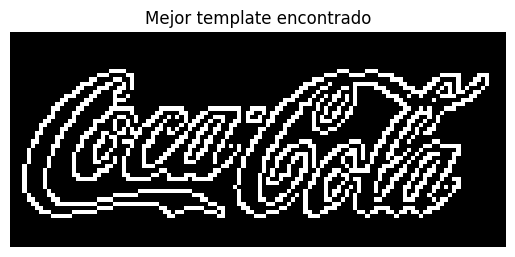

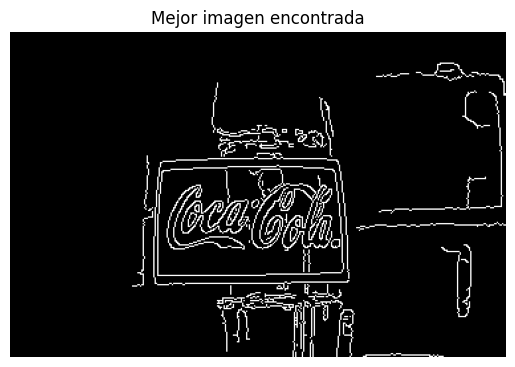

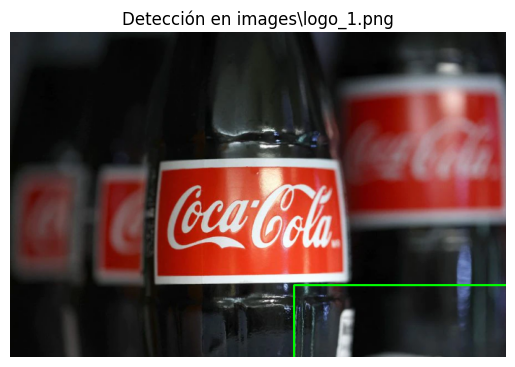

In [8]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import glob

# Los 6 métodos posibles para comparación, a modo de ayudamemoria
methods = ['cv.TM_CCOEFF', 'cv.TM_CCOEFF_NORMED', 'cv.TM_CCORR',
            'cv.TM_CCORR_NORMED', 'cv.TM_SQDIFF', 'cv.TM_SQDIFF_NORMED']

# Cargamos el template en escala de grises
template = cv.imread('template/pattern.png', cv.IMREAD_GRAYSCALE)
template_h, template_w = template.shape  # Tomar las dimensiones del template
print("Tamaño del template original:", template.shape)

# Aplicar el detector de bordes de Canny al template
#template_edges = cv.Canny(template, 50, 150)
#plt.imshow(template_edges, cmap='gray')
#plt.title('Bordes del template original')
#plt.axis('off')
#plt.show()

# Lista de todas las imágenes en la carpeta 'images'
all_images_paths = glob.glob('images/*.*')

# Devolver una lista de copias escaladas del template
def piramide_escalas(img, iteraciones, step = 0.1):
    inicial = img.copy()
    escala_acumulada = 1.0 # Escala inicial
    piramide = [inicial]

    # Escalar el template iterativamente
    for i in range(iteraciones):
        escala_acumulada -= step # Disminuir la escala
        
        # Limitar escala para evitar valores menores o iguales a cero
        if escala_acumulada <= 0:
            break
        
        escalado = cv.resize(inicial, (0, 0), fx=escala_acumulada, fy=escala_acumulada, interpolation=cv.INTER_AREA)
        piramide.append(escalado)

    return piramide

# Devolver una lista de copias escaladas del template según una lista de escalas unformememente distribuidas
def piramide_escalas_mas_menos(img):
    #inicial = img.copy()
    #piramide = [inicial]
    piramide = []
    scales = np.linspace(0.3, 2.5, 10)

    for scale in scales:
        piramide.append(cv.resize(img, None, fx=scale, fy=scale))

    return piramide

# Generar la pirámide de imágenes escaladas del template con sus bordes
# template_pyramid = piramide_escalas(template_edges, 5)
template_pyramid = piramide_escalas_mas_menos(template)
template_pyramid = [cv.Canny(t, 50, 150) for t in template_pyramid] # Aplicar Canny a cada template escalado
scales = np.linspace(0.3, 2.5, len(template_pyramid))

for path in all_images_paths:  # Iterar sobre todas las imágenes
    image = cv.imread(path)  # Cargar la imagen
    gray_image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)  # Convertir la imagen a escala de grises

    # Creo una pirámide de escalas de la imagen
    image_pyramid = piramide_escalas_mas_menos(gray_image)
    image_pyramid = [cv.Canny(t, 50, 150) for t in image_pyramid] # Aplicar Canny a cada imagen escalada

    # Aplicar el detector de bordes de Canny a la imagen completa
    #image_edges = cv.Canny(gray_image, 50, 150)
    #plt.imshow(image_edges, cmap='gray')
    #plt.title(f'Bordes de la Imagen: {path}')
    #plt.axis('off')
    #plt.show()

    # Inicializar las variables para almacenar los mejores resultados
    best_match_val = -1  # Inicializar con un valor bajo
    best_match_location = None
    best_template = None
    best_image = None
    best_scale_factor = 1.0  # Inicializar con el valor de escala 1 (sin escalar)

    for resized_image in image_pyramid:  # Iterar sobre cada nivel de la pirámide de la imagen
        
        # Iterar sobre cada nivel del template en la pirámide
        for level, resized_template in enumerate(template_pyramid):
            tpl_h, tpl_w = resized_template.shape

            # Obtener el factor de escala correspondiente
            scale_factor = scales[level]

            # Asegurarse de que el template no sea más grande que la imagen
            if tpl_h > resized_image.shape[0] or tpl_w > resized_image.shape[1]:
                continue # Pasar al siguiente escalado (si el template es más grande que la imagen lo ignoramos)

            # Aplicar template matching con los bordes
            result = cv.matchTemplate(resized_image, resized_template, cv.TM_CCORR_NORMED)
            min_val, max_val, min_loc, max_loc = cv.minMaxLoc(result)

            # Actualizar la mejor coincidencia si es mejor que la actual
            if max_val > best_match_val:
                best_match_val = max_val
                best_match_location = max_loc
                best_template = resized_template
                best_image = resized_image
                best_scale_factor = scale_factor

    if best_match_location is not None and best_template is not None and best_image is not None:
        # Ajustar las coordenadas para la imagen original usando el factor de escala
        top_left = (
            int(best_match_location[0] / best_scale_factor),
            int(best_match_location[1] / best_scale_factor)
        )
        template_h, template_w = best_template.shape
        bottom_right = (
            int((best_match_location[0] + template_w) / best_scale_factor),
            int((best_match_location[1] + template_h) / best_scale_factor)
        )

        # Dibujar el rectángulo en la imagen original
        cv.rectangle(image, top_left, bottom_right, (0, 255, 0), 2)

        # Dibujar el rectángulo en la mejor coincidencia encontrada
        #top_left = best_match_location
        #template_h, template_w = best_template.shape
        #bottom_right = (top_left[0] + template_w, top_left[1] + template_h)
        #cv.rectangle(best_image, top_left, bottom_right, (0, 255, 0), 2)

        print(f"La similitud máxima fue de {best_match_val:.2f}")
        print(f"El mejor tamaño del template fue de {best_template.shape}")
        print(f"El mejor tamaño de la imagen fue de {best_image.shape}")

        # Mostrar el template que mejor coincidió
        plt.imshow(best_template, cmap='gray')
        plt.title('Mejor template encontrado')
        plt.axis('off')
        plt.show()

        # Mostrar el template que mejor coincidió
        plt.imshow(best_image, cmap='gray')
        plt.title('Mejor imagen encontrada')
        plt.axis('off')
        plt.show()

        # Mostrar el resultado (imagen original con el bounding box dibujado)
        plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
        plt.title(f'Detección en {path}')
        plt.axis('off')
        plt.show()

        # Mostrar el resultado (imagen con el rectángulo dibujado)
        #plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
        #plt.title(f'Detección en {path}')
        #plt.axis('off')
        #plt.show()
    else:
        print(f"No se encontró ninguna coincidencia en {path}")


Tamaño del template original: (175, 400)


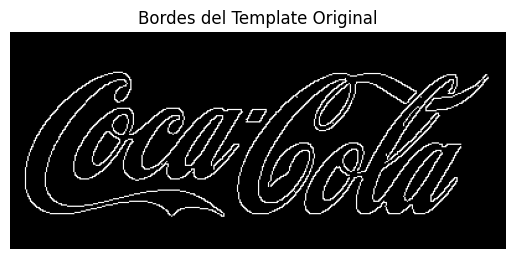

La similitud máxima fue de 0.33
Mejor escala del template: 0.1


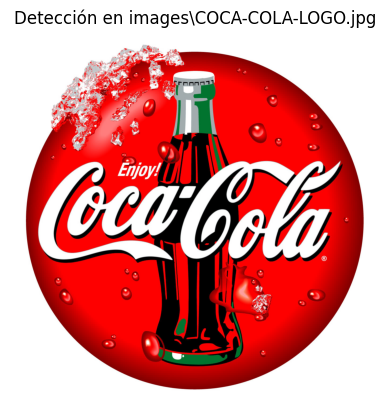

La similitud máxima fue de 0.32
Mejor escala del template: 0.1


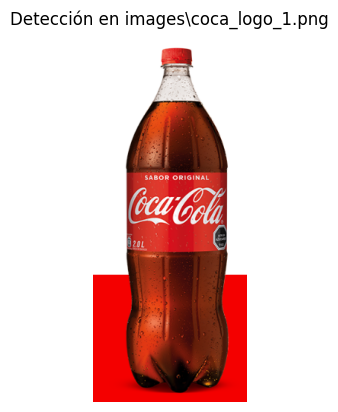

La similitud máxima fue de 0.36
Mejor escala del template: 0.1


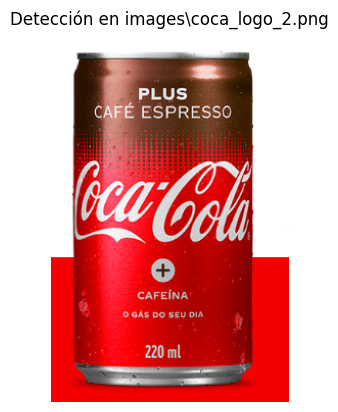

La similitud máxima fue de 0.34
Mejor escala del template: 0.1


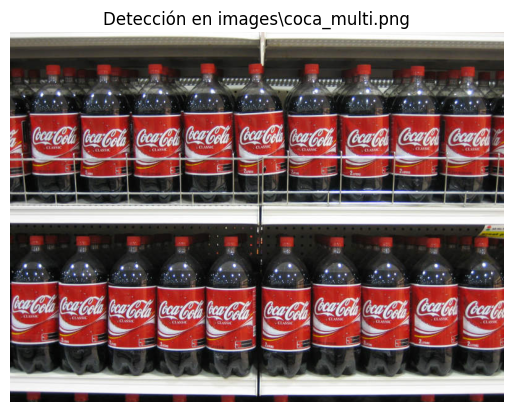

La similitud máxima fue de 0.37
Mejor escala del template: 0.1


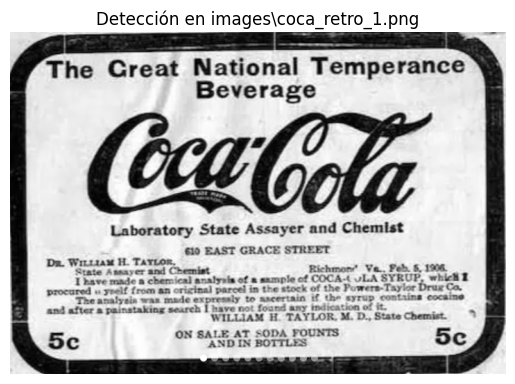

La similitud máxima fue de 0.35
Mejor escala del template: 0.1


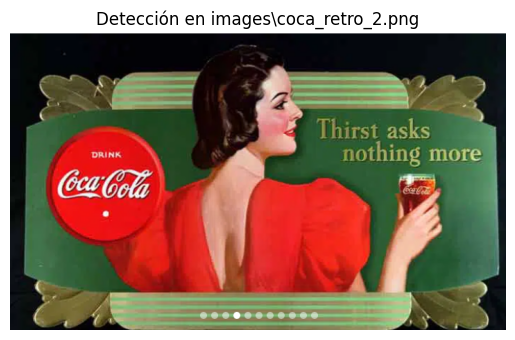

La similitud máxima fue de 0.33
Mejor escala del template: 0.1


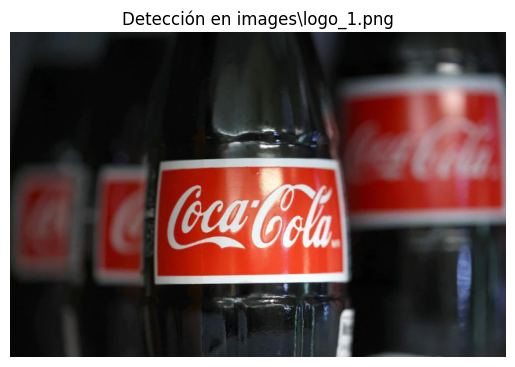

In [ ]:
# EN ESTE LA MEJORA RESPECTO DEL ANTERIOR ES ACOMODAR LA ESCALA DEL BOUNDING BOX PARA QUE SE VEA BIEN EN LA IMAGEN ORIGINAL.
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import glob

# Lista de métodos posibles para comparación
methods = ['cv.TM_CCOEFF', 'cv.TM_CCOEFF_NORMED', 'cv.TM_CCORR',
           'cv.TM_CCORR_NORMED', 'cv.TM_SQDIFF', 'cv.TM_SQDIFF_NORMED']

# Cargar el template en escala de grises
template = cv.imread('template/pattern.png', cv.IMREAD_GRAYSCALE)
template_h, template_w = template.shape
print("Tamaño del template original:", template.shape)

# Aplicar Canny al template para resaltar los bordes
template_edges = cv.Canny(template, 50, 150)
plt.imshow(template_edges, cmap='gray')
plt.title('Bordes del Template Original')
plt.axis('off')
plt.show()

# Lista de todas las imágenes en la carpeta 'images'
all_images_paths = glob.glob('images/*.*')

# Generar una pirámide del template con diferentes escalas (sin cambiar la imagen)
def piramide_escalas_mas_menos(img, scales=np.linspace(0.1, 2.0, 20)):
    #piramide = [img.copy()]
    piramide = []
    for scale in scales:
        piramide.append(cv.resize(img, None, fx=scale, fy=scale))
        #piramide.append(cv.resize(img, None, fx=scale, fy=scale, interpolation=cv.INTER_AREA))
    return piramide

# Crear pirámide del template con Canny aplicado a cada versión
template_pyramid = piramide_escalas_mas_menos(template_edges)
scales = np.linspace(0.1, 2.0, len(template_pyramid))  # Obtener las escalas correspondientes a la pirámide generada

# Iterar sobre todas las imágenes
for path in all_images_paths:
    # Leer la imagen
    image = cv.imread(path)
    gray_image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

    # Aplicar Canny a la imagen para resaltar los bordes
    image_edges = cv.Canny(gray_image, 50, 150)

    # Inicializar las variables para almacenar los mejores resultados
    best_match_val = -1  # Inicializar con un valor bajo
    best_match_location = None
    best_template = None
    best_scale_factor = 1.0  # Inicializar con el valor de escala 1 (sin escalar)

    # Iterar sobre cada nivel del template en la pirámide
    for level, resized_template in enumerate(template_pyramid):
        tpl_h, tpl_w = resized_template.shape

        # Obtener el factor de escala correspondiente
        scale_factor = scales[level]

        # Asegurarse de que el template no sea más grande que la imagen
        if tpl_h > image_edges.shape[0] or tpl_w > image_edges.shape[1]:
            continue  # Ignorar si el template es más grande que la imagen

        # Aplicar template matching con los bordes
        result = cv.matchTemplate(image_edges, resized_template, cv.TM_CCORR_NORMED)
        min_val, max_val, min_loc, max_loc = cv.minMaxLoc(result)

        # Actualizar la mejor coincidencia si es mejor que la actual
        if max_val > best_match_val:
            best_match_val = max_val
            best_match_location = max_loc
            best_template = resized_template
            best_scale_factor = scale_factor

    # Dibujar el bounding box en la imagen original
    if best_match_location is not None:
        # Ajustar las coordenadas para la imagen original usando el factor de escala
        top_left = (
            int(best_match_location[0] / best_scale_factor),
            int(best_match_location[1] / best_scale_factor)
        )
        template_h, template_w = best_template.shape
        bottom_right = (
            int((best_match_location[0] + template_w) / best_scale_factor),
            int((best_match_location[1] + template_h) / best_scale_factor)
        )

        # Dibujar el rectángulo en la imagen original
        cv.rectangle(image, top_left, bottom_right, (0, 255, 0), 2)
        print(f"La similitud máxima fue de {best_match_val:.2f}")
        print(f"Mejor escala del template: {best_scale_factor}")

        # Mostrar el resultado (imagen original con el bounding box dibujado)
        plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
        plt.title(f'Detección en {path}')
        plt.axis('off')
        plt.show()
    else:
        print(f"No se encontró ninguna coincidencia en {path}")


## Parte 2: Algoritmo para múltiples detecciones en 'coca_multi.png'
Para múltiples instancias del logotipo en la imagen coca_multi.png tenemos que ajustar la lógica para permitir múltiples detecciones.

Se dibujan todos los bounding boxes que cumplen con el umbral definido (threshold).

Implementamos la función non_max_suppression() para evitar múltiples detecciones del mismo logo muy cercanas entre sí.

Dibujamos los bounding boxes solo para las detecciones que quedan después de aplicar NMS.

Número total de detecciones antes de NMS: 7
Número de detecciones después de NMS: 2


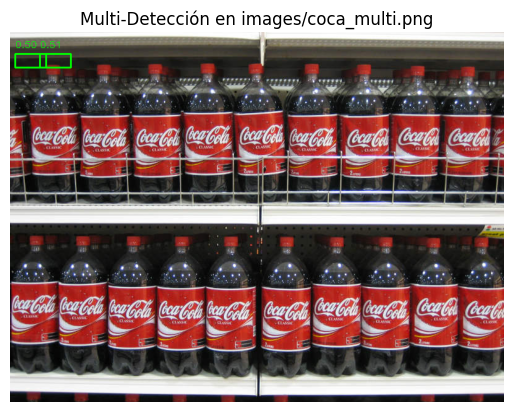

In [7]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

# Encontrar las pirámides Gaussianas de las dos imágenes
def gaussian_pyramid(img, num_levels):
    lower = img.copy()
    gaussian_pyr = [lower]
    for i in range(num_levels):
        lower = cv.pyrDown(lower)
        gaussian_pyr.append(np.uint8(lower))
    return gaussian_pyr

# Función para aplicar NMS
def non_max_suppression(boxes, scores, threshold=0.5):
    if len(boxes) == 0:
        return []

    boxes = np.array(boxes)
    scores = np.array(scores)

    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]

    areas = (x2 - x1 + 1) * (y2 - y1 + 1)
    order = scores.argsort()[::-1]

    keep = []
    while order.size > 0:
        i = order[0]
        keep.append(i)

        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])

        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
        overlap = (w * h) / areas[order[1:]]

        order = order[np.where(overlap <= threshold)[0] + 1]

    return keep

# Cargar la imagen coca_multi.png
multi_image_path = 'images/coca_multi.png'
multi_image = cv.imread(multi_image_path)
gray_multi_image = cv.cvtColor(multi_image, cv.COLOR_BGR2GRAY)

# Cargar el template en escala de grises
template = cv.imread('template/pattern.png', cv.IMREAD_GRAYSCALE)

# Generar la pirámide de Gaussianas del template y de la imagen
template_pyramid = gaussian_pyramid(template, 3)
image_pyramid = gaussian_pyramid(gray_multi_image, 3)

# Lista para guardar los cuadros delimitadores (bounding boxes) y los puntajes
boxes = []
scores = []

# Iterar sobre los niveles de la pirámide
for img_level, tpl_level in zip(image_pyramid, template_pyramid):
    tpl_h, tpl_w = tpl_level.shape
    img_h, img_w = img_level.shape

    # Si el template es más grande que el nivel de imagen, omitir
    if tpl_h > img_h or tpl_w > img_w:
        continue

    # Aplicar template matching en este nivel
    result_multi = cv.matchTemplate(img_level, tpl_level, cv.TM_CCOEFF_NORMED)
    threshold_multi = 0.5  # Ajusta el umbral según la calidad de las detecciones
    locations_multi = np.where(result_multi >= threshold_multi)

    # Guardar las coordenadas de las detecciones y sus puntuaciones
    for pt in zip(*locations_multi[::-1]):
        x1, y1 = pt
        x2, y2 = x1 + tpl_w, y1 + tpl_h
        confidence = result_multi[pt[1], pt[0]]
        boxes.append([x1, y1, x2, y2])
        scores.append(confidence)

print(f"Número total de detecciones antes de NMS: {len(boxes)}")

# Aplicar NMS para eliminar solapamientos
keep_indices = non_max_suppression(boxes, scores, threshold=0.4)

# Dibujar los bounding boxes finales
for idx in keep_indices:
    x1, y1, x2, y2 = boxes[idx]
    confidence = scores[idx]
    cv.rectangle(multi_image, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv.putText(multi_image, f'{confidence:.2f}', (x1, y1 - 10), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

print(f"Número de detecciones después de NMS: {len(keep_indices)}")

# Mostrar el resultado
plt.imshow(cv.cvtColor(multi_image, cv.COLOR_BGR2RGB))
plt.title(f'Multi-Detección en {multi_image_path}')
plt.axis('off')
plt.show()

Imagen Shape: 598x799
Template Shape: 175x400
El número de coincidencias para un umbral de 0.3 fue de 3452


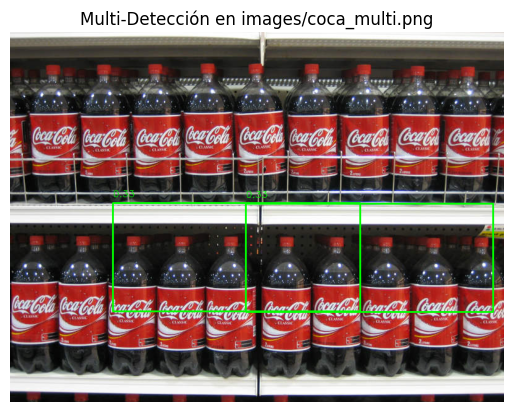

In [ ]:

### GUARDADO SOLO A FINES DE BACKUP ###
## CODIGO ANTERIOR LO MEJORA ##
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

# Encontrar las pirámides Gaussianas de las dos imágenes y la máscara (COPIADO DEL REPO DE LA MATERIA)
def gaussian_pyramid(img, num_levels):
    lower = img.copy()
    gaussian_pyr = [lower]
    for i in range(num_levels):
        lower = cv.pyrDown(lower)
        gaussian_pyr.append(np.uint8(lower))
    return gaussian_pyr

# Función para aplicar NMS
def non_max_suppression(boxes, scores, threshold=0.5):
    if len(boxes) == 0:
        return []

    boxes = np.array(boxes)
    scores = np.array(scores)

    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]

    areas = (x2 - x1 + 1) * (y2 - y1 + 1)
    order = scores.argsort()[::-1]

    keep = []
    while order.size > 0:
        i = order[0]
        keep.append(i)

        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])

        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
        overlap = (w * h) / areas[order[1:]]

        order = order[np.where(overlap <= threshold)[0] + 1]

    return keep

# Cargar la imagen coca_multi.png
multi_image_path = 'images/coca_multi.png'
multi_image = cv.imread(multi_image_path)
gray_multi_image = cv.cvtColor(multi_image, cv.COLOR_BGR2GRAY)
gray_h, gray_w = gray_multi_image.shape

# Cargamos el template en escala de grises
template = cv.imread('template/pattern.png', cv.IMREAD_GRAYSCALE)
template_h, template_w = template.shape # Tomamos las dimensiones del template

print(f"Imagen Shape: {gray_h}x{gray_w}")
print(f"Template Shape: {template_h}x{template_w}")
# Ajustar el tamaño del template si es más grande que la imagen
scaled_template = template.copy()
scaled_template_h, scaled_template_w = scaled_template.shape
if template_h > gray_h or template_w > gray_w:
    # Calcular la relación de escalado necesaria para que el template quepa dentro de la imagen
    scale_factor_h = gray_h / template_h
    scale_factor_w = gray_w / template_w
    scale_factor = min(scale_factor_h, scale_factor_w)

    # Escalar el template
    new_template_w = int(template_w * scale_factor)
    new_template_h = int(template_h * scale_factor)
    scaled_template_h, scaled_template_w = new_template_h, new_template_w

    scaled_template = cv.resize(scaled_template, (new_template_w, new_template_h), interpolation=cv.INTER_AREA)
    print(f"El template fue redimensionado a: {new_template_w}x{new_template_h}")

# Aplicar template matching
result_multi = cv.matchTemplate(gray_multi_image, scaled_template, cv.TM_CCOEFF_NORMED)
threshold_multi = 0.3
locations_multi = np.where(result_multi >= threshold_multi)

print(f"El número de coincidencias para un umbral de {threshold_multi} fue de {len(locations_multi[0])}")

# Guardar las coordenadas de las detecciones y sus puntuaciones
boxes = []
scores = []

for pt in zip(*locations_multi[::-1]):
    x1, y1 = pt
    x2, y2 = x1 + scaled_template_w, y1 + scaled_template_h
    confidence = result_multi[pt[1], pt[0]]
    boxes.append([x1, y1, x2, y2])
    scores.append(confidence)

# Aplicar NMS para eliminar solapamientos
keep_indices = non_max_suppression(boxes, scores, threshold=0.5)

# Dibujar los bounding boxes finales
for idx in keep_indices:
    x1, y1, x2, y2 = boxes[idx]
    confidence = scores[idx]
    cv.rectangle(multi_image, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv.putText(multi_image, f'{confidence:.2f}', (x1, y1 - 10), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

# Mostrar el resultado
plt.imshow(cv.cvtColor(multi_image, cv.COLOR_BGR2RGB))
plt.title(f'Multi-Detección en {multi_image_path}')
plt.axis('off')
plt.show()

# DE AQUÍ HACIA ABAJO FUNCIONA BIEN, PERO VAMOS A CAMBIAR POR NMS
#w, h = template.shape[::-1]
# Dibujar bounding boxes para cada coincidencia
#for pt in zip(*locations_multi[::-1]):
#    cv.rectangle(multi_image, pt, (pt[0] + template_w, pt[1] + template_h), (0, 255, 0), 2)
#    confidence = result_multi[pt[1], pt[0]]
#    cv.putText(multi_image, f'{confidence:.2f}', (pt[0], pt[1] - 10), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

# Mostrar el resultado
#plt.imshow(cv.cvtColor(multi_image, cv.COLOR_BGR2RGB))
#plt.title('Múltiples detecciones en coca_multi.png')
#plt.axis('off')
#plt.show()

Número total de detecciones antes de NMS: 109
Número de detecciones después de NMS: 2


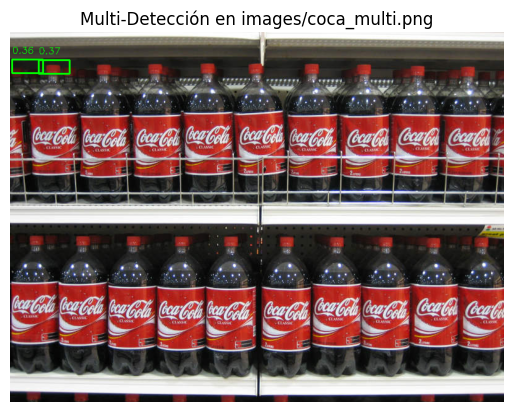

In [11]:
## MEJORA APLICANDO CANNY A LA IMAGEN Y AL TEMPLATE
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

# Encontrar las pirámides Gaussianas de las dos imágenes
def gaussian_pyramid(img, num_levels):
    lower = img.copy()
    gaussian_pyr = [lower]
    for i in range(num_levels):
        lower = cv.pyrDown(lower)
        gaussian_pyr.append(np.uint8(lower))
    return gaussian_pyr

# Función para aplicar NMS
def non_max_suppression(boxes, scores, threshold=0.5):
    if len(boxes) == 0:
        return []

    boxes = np.array(boxes)
    scores = np.array(scores)

    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]

    areas = (x2 - x1 + 1) * (y2 - y1 + 1)
    order = scores.argsort()[::-1]

    keep = []
    while order.size > 0:
        i = order[0]
        keep.append(i)

        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])

        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
        overlap = (w * h) / areas[order[1:]]

        order = order[np.where(overlap <= threshold)[0] + 1]

    return keep

# Cargar la imagen coca_multi.png
multi_image_path = 'images/coca_multi.png'
multi_image = cv.imread(multi_image_path)
gray_multi_image = cv.cvtColor(multi_image, cv.COLOR_BGR2GRAY)

# Aplicar Canny a la imagen para obtener sus bordes
image_edges = cv.Canny(gray_multi_image, 50, 150)

# Cargar el template en escala de grises y aplicar Canny
template = cv.imread('template/pattern.png', cv.IMREAD_GRAYSCALE)
template_edges = cv.Canny(template, 50, 150)

# Generar la pirámide de Gaussianas del template (con sus bordes) y de la imagen (con sus bordes)
template_pyramid = gaussian_pyramid(template_edges, 3)
image_pyramid = gaussian_pyramid(image_edges, 3)

# Lista para guardar los cuadros delimitadores (bounding boxes) y los puntajes
boxes = []
scores = []

# Iterar sobre los niveles de la pirámide
for img_level, tpl_level in zip(image_pyramid, template_pyramid):
    tpl_h, tpl_w = tpl_level.shape
    img_h, img_w = img_level.shape

    # Si el template es más grande que el nivel de imagen, omitir
    if tpl_h > img_h or tpl_w > img_w:
        continue

    # Aplicar template matching en este nivel usando las imágenes con bordes
    result_multi = cv.matchTemplate(img_level, tpl_level, cv.TM_CCOEFF_NORMED)
    threshold_multi = 0.3  # Ajusta el umbral según la calidad de las detecciones
    locations_multi = np.where(result_multi >= threshold_multi)

    # Guardar las coordenadas de las detecciones y sus puntuaciones
    for pt in zip(*locations_multi[::-1]):
        x1, y1 = pt
        x2, y2 = x1 + tpl_w, y1 + tpl_h
        confidence = result_multi[pt[1], pt[0]]
        boxes.append([x1, y1, x2, y2])
        scores.append(confidence)

print(f"Número total de detecciones antes de NMS: {len(boxes)}")

# Aplicar NMS para eliminar solapamientos
keep_indices = non_max_suppression(boxes, scores, threshold=0.4)

# Dibujar los bounding boxes finales en la imagen original
for idx in keep_indices:
    x1, y1, x2, y2 = boxes[idx]
    confidence = scores[idx]
    cv.rectangle(multi_image, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv.putText(multi_image, f'{confidence:.2f}', (x1, y1 - 10), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

print(f"Número de detecciones después de NMS: {len(keep_indices)}")

# Mostrar el resultado
plt.imshow(cv.cvtColor(multi_image, cv.COLOR_BGR2RGB))
plt.title(f'Multi-Detección en {multi_image_path}')
plt.axis('off')
plt.show()


## Parte 3: Generalización del algoritmo para todas las imágenes.
Vamos a generalizar el algoritmo para todas las imágenes de la carpeta y usaremos el método de supresión de no máximos (NMS) para evitar solapamientos innecesarios en las detecciones.

Usamos glob para iterar sobre todas las imágenes en la carpeta 'images'.

Implementamos la función non_max_suppression() para evitar múltiples detecciones del mismo logo muy cercanas entre sí.

Dibujamos los bounding boxes solo para las detecciones que quedan después de aplicar NMS.

In [18]:
import glob

# Función para aplicar NMS
def non_max_suppression(boxes, scores, threshold=0.5):
    if len(boxes) == 0:
        return []

    boxes = np.array(boxes)
    scores = np.array(scores)

    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]

    areas = (x2 - x1 + 1) * (y2 - y1 + 1)
    order = scores.argsort()[::-1]

    keep = []
    while order.size > 0:
        i = order[0]
        keep.append(i)

        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])

        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
        overlap = (w * h) / areas[order[1:]]

        order = order[np.where(overlap <= threshold)[0] + 1]

    return keep

# Generalizar para todas las imágenes
all_images_paths = glob.glob('images/*.png')

for path in all_images_paths:
    # Leer la imagen
    image = cv.imread(path)
    gray_image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

    # Aplicar template matching
    result = cv.matchTemplate(gray_image, template, cv.TM_CCOEFF_NORMED)
    threshold = 0.8
    locations = np.where(result >= threshold)

    # Guardar las coordenadas de las detecciones y sus puntuaciones
    boxes = []
    scores = []

    for pt in zip(*locations[::-1]):
        x1, y1 = pt
        x2, y2 = x1 + template_w, y1 + template_h
        confidence = result[pt[1], pt[0]]
        boxes.append([x1, y1, x2, y2])
        scores.append(confidence)

    # Aplicar NMS para eliminar solapamientos
    keep_indices = non_max_suppression(boxes, scores, threshold=0.5)

    # Dibujar los bounding boxes finales
    for idx in keep_indices:
        x1, y1, x2, y2 = boxes[idx]
        confidence = scores[idx]
        cv.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv.putText(image, f'{confidence:.2f}', (x1, y1 - 10), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

    # Mostrar el resultado
    plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
    plt.title(f'Detección generalizada en {path}')
    plt.axis('off')
    plt.show()


error: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\templmatch.cpp:1175: error: (-215:Assertion failed) _img.size().height <= _templ.size().height && _img.size().width <= _templ.size().width in function 'cv::matchTemplate'


## Parte 4: Puntos extra. Aplicar unsharp masking para expandir la zona de enfoque y devolver.
Vamos a aplicar unsharp masking para mejorar la nitidez de las imágenes y expandir la zona de enfoque. Esto resalta los detalles al aumentar el contraste de los bordes haciendo así que el logotipo sea más visible antes de la detección.

In [ ]:
def unsharp_mask(image, kernel_size=(5, 5), sigma=1.0, amount=1.5, threshold=0):
    # Aplicar suavizado Gaussian a la imagen
    blurred = cv2.GaussianBlur(image, kernel_size, sigma)

    # Calcular la máscara
    mask = cv2.addWeighted(image, 1 + amount, blurred, -amount, 0)

    # Aplicar umbral para mejorar detalles
    if threshold > 0:
        low_contrast_mask = np.abs(image - blurred) < threshold
        np.copyto(mask, image, where=low_contrast_mask)

    return mask

# Lista de imágenes a procesar
all_images_paths = glob.glob('images/*.png')

# Cargar el template
template = cv2.imread('template.png', cv2.IMREAD_GRAYSCALE)
template_h, template_w = template.shape

for path in all_images_paths:
    # Leer la imagen
    image = cv2.imread(path)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Aplicar Unsharp Masking
    sharpened_image = unsharp_mask(gray_image, kernel_size=(5, 5), sigma=1.0, amount=1.5, threshold=10)

    # Aplicar template matching sobre la imagen mejorada
    result = cv2.matchTemplate(sharpened_image, template, cv2.TM_CCOEFF_NORMED)
    threshold = 0.8
    locations = np.where(result >= threshold)

    # Dibujar los bounding boxes para cada coincidencia
    for pt in zip(*locations[::-1]):
        cv2.rectangle(image, pt, (pt[0] + template_w, pt[1] + template_h), (0, 255, 0), 2)
        confidence = result[pt[1], pt[0]]
        cv2.putText(image, f'{confidence:.2f}', (pt[0], pt[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

    # Mostrar el resultado
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(f'Detección con Unsharp Masking en {path}')
    plt.axis('off')
    plt.show()


Lo que hicimos fue aplicar unsharp_mask a la imagen en escala de grises para resaltar los bordes y después realizamos template matching con la imagen mejorada para detectar el logotipo.